In [1]:
import pandas as pd

In [2]:
import sqlite3

## 从数据库中读取数据

In [4]:
# Connect to the SQLite database
connection = sqlite3.connect("../getTradeData/binance-15.db")

# Define the SQL query
sql_query = "SELECT * FROM BTCUSDT"

# Read data from the SQLite database into a pandas DataFrame
df = pd.read_sql_query(sql_query, connection)

# Close the database connection
connection.close()

In [5]:
df.head(10)

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1504254600000,4731.12000000,4750.00000000,4731.12000000,4749.63000000,4.61437000,1504255499999,21908.50661169,38,2.02487400,9617.83400448,0
1,1504255500000,4750.00000000,4750.00000000,4731.00000000,4749.99000000,13.83106500,1504256399999,65600.14256819,54,3.65415200,17357.21437722,0
2,1504256400000,4731.01000000,4749.99000000,4731.00000000,4745.32000000,6.65224700,1504257299999,31569.41301905,41,1.34804100,6403.18126959,0
3,1504257300000,4745.32000000,4749.99000000,4731.01000000,4749.99000000,8.07911800,1504258199999,38321.54014645,46,1.28099900,6084.73244001,0
4,1504258200000,4749.99000000,4750.00000000,4731.00000000,4731.01000000,11.26265300,1504259099999,53382.21142245,83,3.06902000,14569.45576377,0
5,1504259100000,4731.01000000,4749.99000000,4731.00000000,4742.46000000,8.77782100,1504259999999,41572.07003814,60,1.63936000,7764.50608107,0
6,1504260000000,4739.33000000,4742.47000000,4735.98000000,4735.98000000,3.46048300,1504260899999,16402.52761525,20,0.86838000,4118.26609860,0
7,1504260900000,4735.98000000,4778.19000000,4735.98000000,4766.01000000,6.78084100,1504261799999,32215.92640801,24,3.64675100,17316.36281321,0
8,1504261800000,4755.28000000,4766.00000000,4753.77000000,4766.00000000,8.47755000,1504262699999,40338.80502081,52,0.10247800,488.41014800,0
9,1504262700000,4764.87000000,4776.29000000,4761.41000000,4761.42000000,8.58154100,1504263599999,40899.67738231,93,0.67906900,3240.80405189,0


In [5]:
# 将字符串类型的数值列转换为浮点数
numeric_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
df[numeric_columns] = df[numeric_columns].astype(float)

## 特征工程

In [6]:
# Calculate RSI
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# Calculate EMA
ema_short = df['close'].ewm(span=12).mean()
ema_long = df['close'].ewm(span=26).mean()

# Calculate MACD
macd = ema_short - ema_long
signal_line = macd.ewm(span=9).mean()
histogram = macd - signal_line

# Add RSI, EMA, and MACD to the DataFrame
df['rsi'] = rsi
df['ema_short'] = ema_short
df['ema_long'] = ema_long
df['macd'] = macd
df['signal_line'] = signal_line
df['histogram'] = histogram

df['sma_3'] = df['close'].rolling(window=3).mean()
df['sma_6'] = df['close'].rolling(window=6).mean()
df['sma_12'] = df['close'].rolling(window=12).mean()
# 波动率
df['volatility_std'] = df['close'].rolling(window=5).std()
df['pct_change'] = df['close'].pct_change()
df['sma_20'] = df['close'].rolling(window=20).mean()
df['std_20'] = df['close'].rolling(window=20).std()
df['bollinger_upper'] = df['sma_20'] + 2 * df['std_20']
df['bollinger_middle'] = df['sma_20']
df['bollinger_lower'] = df['sma_20'] - 2 * df['std_20']
df['diff_bollinger_upper'] = df['close'] - df['bollinger_upper']
df['diff_bollinger_lower'] = df['close'] - df['bollinger_lower']
df['diff_sma_3'] = df['close'] - df['sma_3']
df['diff_sma_6'] = df['close'] - df['sma_6']
df['diff_sma_12'] = df['close'] - df['sma_12']

In [7]:
df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,sma_20,std_20,bollinger_upper,bollinger_middle,bollinger_lower,diff_bollinger_upper,diff_bollinger_lower,diff_sma_3,diff_sma_6,diff_sma_12
0,1504254600000,4731.12,4750.00,4731.12,4749.63,4.614370,1504255499999,21908.506612,38,2.024874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1504255500000,4750.00,4750.00,4731.00,4749.99,13.831065,1504256399999,65600.142568,54,3.654152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1504256400000,4731.01,4749.99,4731.00,4745.32,6.652247,1504257299999,31569.413019,41,1.348041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.993333,NaN,NaN
3,1504257300000,4745.32,4749.99,4731.01,4749.99,8.079118,1504258199999,38321.540146,46,1.280999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.556667,NaN,NaN
4,1504258200000,4749.99,4750.00,4731.00,4731.01,11.262653,1504259099999,53382.211422,83,3.069020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.096667,NaN,NaN


In [8]:
# 丢弃前20行含有nan的数据
df = df.iloc[20:]
df.reset_index(drop=True, inplace=True)

## 确定买入、卖出的时机

### 滑动窗口方法
* 找到滑动窗口的最大值和最小值的下标，如果下标等于起始标记和结束标记则不标记，否则记录最大值和最小值的下标

* 看了前n轮的数据预测n+1轮
* 由于我们想预测的是买入的时间节点，所以需要对数据进行处理，买入为1，持有为2，卖出为3
* 算法类似于求出数据列的最小子项和（在一个数组中，有 【0 1 -2 2 2 4 5 -10】求出最大的值，记录下标即可）
* 可能出现的情况，
* 1）在连续上涨的行情中回调很小，如果限定时间窗口会影响收益情况，这个时候应该限制最小的时间窗口
* 2）在震荡行情中，不适合开单，
* 考虑到我们的是15分钟的数据，并且是做波段，

In [9]:
close = df[['close']]

In [10]:
close  = close.values.tolist()

In [11]:
close = [item for sublist in close for item in sublist]

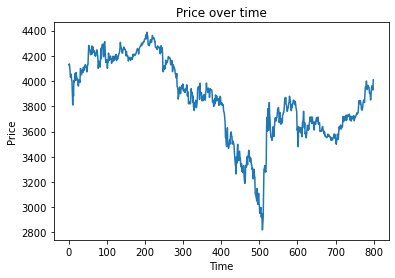

In [12]:
import matplotlib.pyplot as plt

# Your data
data = close[800:1600]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot data
ax.plot(data)

# Set labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Price over time')

# Show the plot
plt.show()


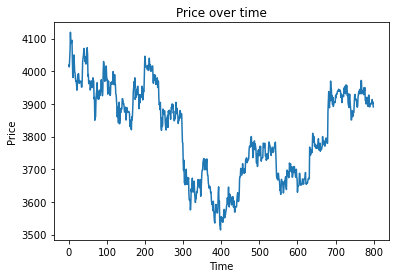

In [13]:
data = close[1600:2400]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot data
ax.plot(data)

# Set labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Price over time')

# Show the plot
plt.show()


In [54]:
def find_extrema_indices(close, window_size):
    max_indices = []
    min_indices = []

    for i in range(0, len(close) - window_size + 1):
        window = close[i:i+window_size]
        max_value = max(window)
        min_value = min(window)
        max_index = window.index(max_value) + i
        min_index = window.index(min_value) + i
        if max_index != i and max_index != i + window_size - 1 and max_index not in max_indices:
            max_indices.append(max_index)
        if min_index != i and min_index != i + window_size - 1 and min_index not in min_indices:
            min_indices.append(min_index)
    
    return min_indices,max_indices 


In [58]:
max_indices,min_indices = find_extrema_indices(close,300)

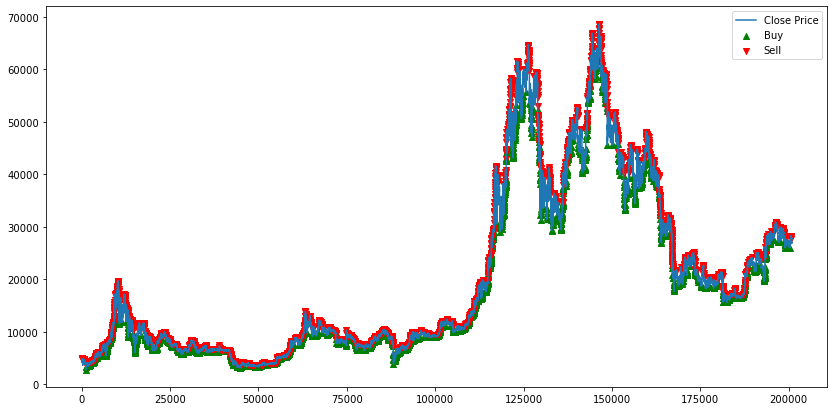

In [56]:
plt.figure(figsize=(14,7))
plt.plot(close, label='Close Price')
plt.scatter(max_indices, [close[i] for i in max_indices], color='g', marker='^', label='Buy')
plt.scatter(min_indices, [close[i] for i in min_indices], color='r', marker='v', label='Sell')
plt.legend()
plt.show()


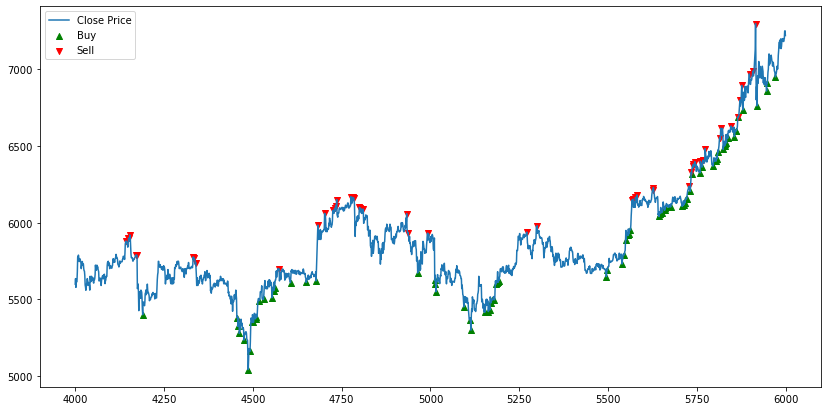

In [59]:
start, end = 4000, 6000

# Filter the indices within the range
max_indices_range = [i for i in max_indices if start <= i < end]
min_indices_range = [i for i in min_indices if start <= i < end]

plt.figure(figsize=(14,7))
plt.plot(range(start, end), close[start:end], label='Close Price')
plt.scatter(max_indices_range, [close[i] for i in max_indices_range], color='g', marker='^', label='Buy')
plt.scatter(min_indices_range, [close[i] for i in min_indices_range], color='r', marker='v', label='Sell')
plt.legend()
plt.show()

### 由于有多个买入和卖出的点，改为不滑动的窗口重新校验


In [14]:
def find_extrema_indices_no_slip(close, window_size):
    max_indices = []
    min_indices = []

    for i in range(0, len(close) - window_size + 1, window_size):
        window = close[i:i+window_size]
        max_value = max(window)
        min_value = min(window)
        max_index = window.index(max_value) + i
        min_index = window.index(min_value) + i
        if max_index != i and max_index != i + window_size - 1 and max_index not in max_indices:
            max_indices.append(max_index)
        if min_index != i and min_index != i + window_size - 1 and min_index not in min_indices:
            min_indices.append(min_index)
    
    return max_indices, min_indices


In [20]:
min_indices,max_indices = find_extrema_indices_no_slip(close,300)

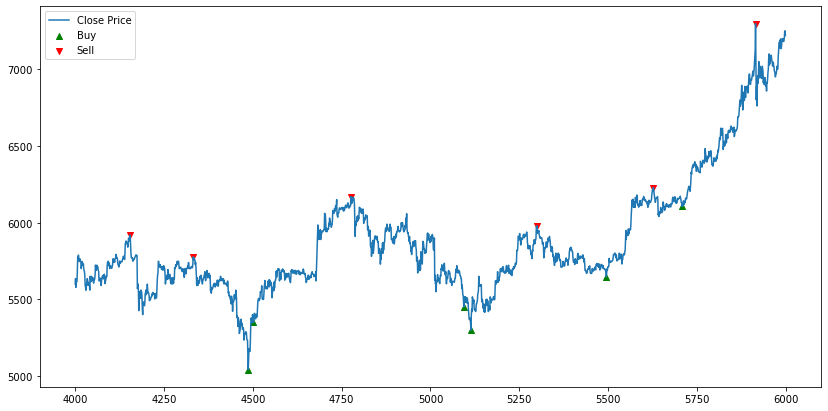

In [21]:
start, end = 4000, 6000

# Filter the indices within the range
max_indices_range = [i for i in max_indices if start <= i < end]
min_indices_range = [i for i in min_indices if start <= i < end]

plt.figure(figsize=(14,7))
plt.plot(range(start, end), close[start:end], label='Close Price')
plt.scatter(max_indices_range, [close[i] for i in max_indices_range], color='g', marker='^', label='Buy')
plt.scatter(min_indices_range, [close[i] for i in min_indices_range], color='r', marker='v', label='Sell')
plt.legend()
plt.show()

### 到这一步还是有多个买入和卖出的点，需要对数据进一步进行处理，让一个买入对应一个卖出
* 首先，将 max_indices 和 min_indices 合并并排序。
* 然后，遍历排序后的列表，如果当前索引在 max_indices 中，那么下一个在 min_indices 中的索引就是与当前最大值对应的最小值。
* 最后，将对应的最大值和最小值的索引添加到新的列表中。

In [27]:
def pair_max_min(max_indices, min_indices):
    paired_max_indices = []
    paired_min_indices = []

    # Merge and sort indices
    all_indices = sorted(max_indices + min_indices)

    for i in range(len(all_indices) - 1):
        if all_indices[i] in max_indices and all_indices[i+1] in min_indices:
            paired_max_indices.append(all_indices[i])
            paired_min_indices.append(all_indices[i+1])

    return paired_max_indices, paired_min_indices


In [28]:
buy_indices,sell_indices = pair_max_min(max_indices, min_indices)

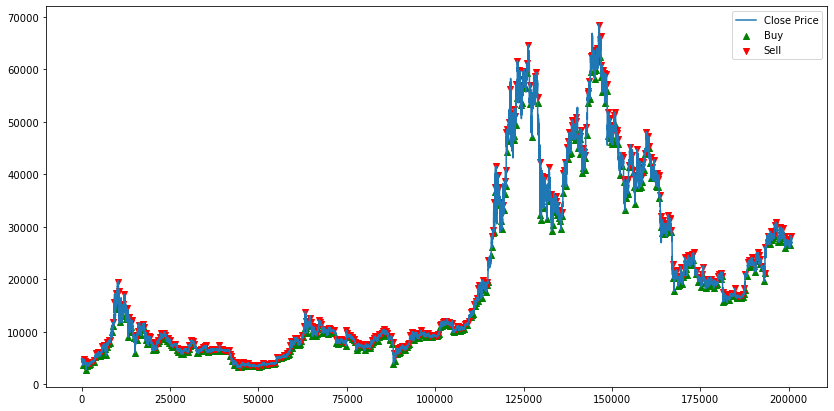

In [51]:
start, end = 0, len(close)

# Filter the indices within the range
max_indices_range = [i for i in buy_indices if start <= i < end]
min_indices_range = [i for i in sell_indices if start <= i < end]

plt.figure(figsize=(14,7))
plt.plot(range(start, end), close[start:end], label='Close Price')
plt.scatter(max_indices_range, [close[i] for i in max_indices_range], color='g', marker='^', label='Buy')
plt.scatter(min_indices_range, [close[i] for i in min_indices_range], color='r', marker='v', label='Sell')
plt.legend()
plt.show()

In [32]:
len(close),len(buy_indices),len(sell_indices)

(200854, 469, 469)

### 将买入点添加到买入特征当中
* 1 - 不操作 2 - 买入 3 - 卖出

In [40]:
buy_sell_signal = [1]*200854

In [42]:
for buy in buy_indices:
    buy_sell_signal[buy] = 2

In [43]:
for buy in sell_indices:
    buy_sell_signal[buy] = 3

In [45]:
len(buy_sell_signal),len(close)

(200854, 200854)

In [47]:
df[['signal']] = pd.DataFrame(data=buy_sell_signal)

### 计算买入和卖出之间间隔的最大值、中位数、最小值
这一步是为了找到每次输入多少时间周期的数据

In [52]:
import statistics


intervals = [min_i - max_i for max_i, min_i in zip(buy_indices, sell_indices)]

min_interval = min(intervals)
max_interval = max(intervals)
median_interval = statistics.median(intervals)
average_interval = sum(intervals) / len(intervals)


print(f"Min interval: {min_interval}")
print(f"Max interval: {max_interval}")
print(f"Median interval: {median_interval}")
print(f"Average interval: {average_interval}")

Min interval: 8
Max interval: 449
Median interval: 159
Average interval: 163.18763326226014


### 对数据进行划分

In [56]:
from sklearn.preprocessing import MinMaxScaler

# 假设你的数据存储在一个名为 df 的 pandas DataFrame 中
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [58]:
import numpy as np
def split_data(data, lookback, train_ratio=0.9):
    n = len(data)
    train_size = int(n * train_ratio)
    
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    X_train = np.array([train_data[i:i+lookback] for i in range(len(train_data) - lookback)])
    y_train = np.array([train_data.iloc[i+lookback][['high', 'low', 'signal']] for i in range(len(train_data) - lookback)])
    
    X_test = np.array([test_data[i:i+lookback] for i in range(len(test_data) - lookback)])
    y_test = np.array([test_data.iloc[i+lookback][['high', 'low', 'signal']] for i in range(len(test_data) - lookback)])
    
    return X_train, y_train, X_test, y_test

lookback = 211
X_train, y_train, X_test, y_test = split_data(df_scaled, lookback)


### 使用xgb进行训练和验证

In [ ]:
import xgboost as xgb

# 定义 XGBoost 模型的参数
params = {
    'objective': 'multi:softmax',  # 多分类问题，使用 softmax 作为目标函数
    'num_class': 3,  # 类别数量
    'max_depth': 6,  # 树的最大深度
    'eta': 0.1,  # 学习率
    'subsample': 0.8,  # 样本子采样比例
    'colsample_bytree': 0.8,  # 特征子采样比例
    'eval_metric': 'merror'  # 评估指标，这里使用分类错误率
}

# 创建 DMatrix 对象
dtrain = xgb.DMatrix(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), label=y_train)
dtest = xgb.DMatrix(X_test.reshape(-1, X_test.shape[1]*X_test.shape[2]))

# 训练模型
model = xgb.train(params, dtrain)

# 进行预测
y_pred = model.predict(dtest)


## referance

https://www.analyticsvidhya.com/blog/2020/11/stock-market-price-trend-prediction-using-time-series-forecasting/